# Exploratory Data Analysis


## Cleaning

In [2]:
import numpy as np
import pandas as pd
import datetime # manipulating date formats
import os
import seaborn as sns

from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL

# settings
plt.style.use('seaborn-deep')

We start by reading the data and transform it to a suitable form. This means dropping unnecessary columns and setting the right data frequency.

In [3]:
ts = pd.read_csv("daily.csv", parse_dates = ['timestamp'])
ts.rename(columns={"timestamp": "Date", "value": "kWh"},inplace=True)
ts = ts.set_index('Date')[["kWh"]]
ts = ts.sum(level='Date').sort_index().asfreq('d')
ts.head(15)

,kWh
Date,
2017-01-01,399131.94
2017-01-02,545259.57
2017-01-03,557400.78
2017-01-04,557394.31
2017-01-05,554266.71
2017-01-06,484772.87
2017-01-07,448601.37
2017-01-08,433151.95
2017-01-09,638036.96


<AxesSubplot:xlabel='Date'>

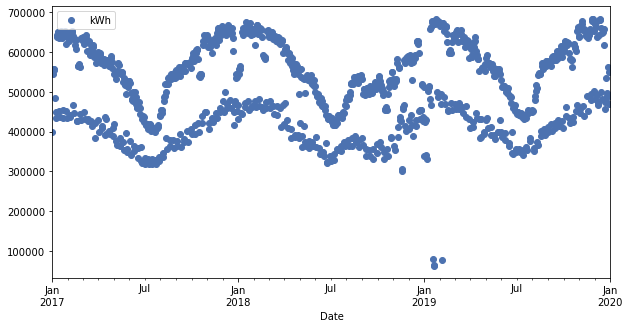

In [4]:
ts.plot(figsize=(10,5),style="o")

We can see that there is a clear year over year seasonality, with some irregularities from the end of 2018 to the beginning of 2019. This may be due to the gathering process at the source of the data. Let us examine next if there is any need to clean the data.

In [5]:
print(ts.info())
ts.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1096 entries, 2017-01-01 to 2020-01-01
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kWh     1096 non-null   float64
dtypes: float64(1)
memory usage: 17.1 KB
None


,kWh
count,1096.000000
mean,513641.385976
std,101693.964087
min,61980.910000
25%,434430.260000
50%,519402.665000
75%,597521.062500
max,683808.340000


Fortunately, the data is already in good shape. We only need to save the data now.

In [6]:
file_name = 'cleaned-daily.csv'
ts.to_csv(f"./{file_name}")

## Data Visualization

First, we can take a look at the consumption during each year.

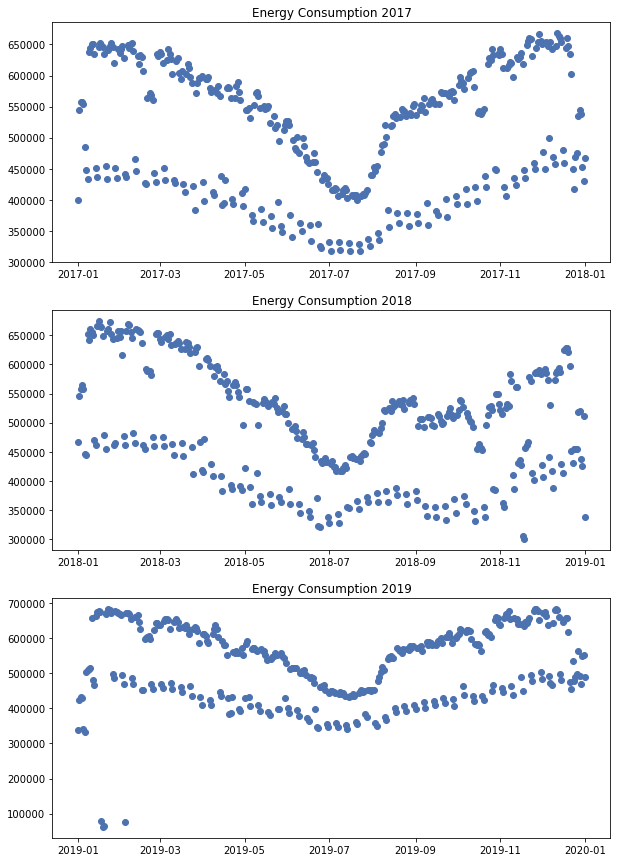

In [7]:
ts2017,ts2018,ts2019 = ts['2017-01-01':'2018-01-01'],ts['2018-01-01':'2019-01-01'],ts['2019-01-01':'2020-01-01']
fig,ax =  plt.subplots(3,figsize=(10,15))

ax[0].plot(ts2017,'o')
ax[0].set_title('Energy Consumption 2017')
ax[1].plot(ts2018,'o')
ax[1].set_title('Energy Consumption 2018')
ax[2].plot(ts2019,'o')
ax[2].set_title('Energy Consumption 2019')

plt.show()

The seasonality within each year is very much predictable. The demand peaks in winter-spring then bottoms out during summer.

We now proceed to zoom in the plot further, investigating monthly, weekly and daily time periods.

Text(0.5, 0.98, 'Energy Consumption in January 2017')

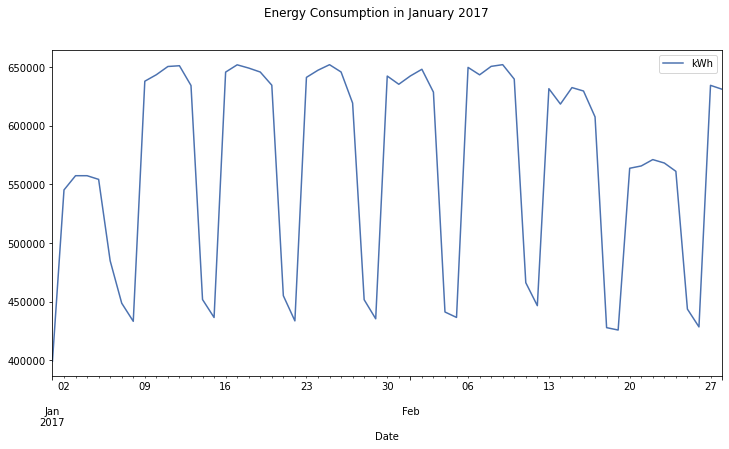

In [22]:
feb_end = '2017-02-28'

ts.loc[:feb_end].plot(figsize = (12,6))
plt.suptitle('Energy Consumption in January 2017')

Upon examining the plot, we can see that there is a very visible pattern occuring every 7 days. Therefore, it can be deduced that there is a weekly seasonality within the time series. We can further explore this pattern by looking at the day of the weeks of the time period.

In [21]:
# The day of the week with Monday=0,..., Sunday=6
ts.loc[:feb_end].index.dayofweek

Int64Index([6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6,
            0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0,
            1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1],
           dtype='int64', name='Date')

From the result, we can see that energy consumption level is at its height during the weekdays, then drops significantly during the weekends. This very much fits our expectation, since factories and workplaces, which follow such a schedule, are places that consume the most energy.

In the following section, we will further investigate the time series by decomposing it in to the 3 components:
* Trend-cycle - increases or decreases within the data in the long-term or not of a fixed frequency. 
* Seasonal - pattern occurs when a time series is affected by seasonal factors.
* Residuals - the remainder after removing the 2 aforementioned components.

If we are looking at an additive decomposition, this can be mathematically formulated as
$$
y_t = S_t + T_t + R_t,
$$
where $y_t$ is the data, $S_t$ is the seasonal component, $T_t$ is the trend-cycle component, and $R_t$ is the remainder component, all at period $t$. Similarly, a multiplicative decomposition would be written as
$$
y_t = S_t \times T_t \times R_t.
$$

Further reading: [Forecasting: Principles and Practice - Rob J Hyndman and George Athanasopoulos](https://otexts.com/fpp2/components.html).

We first apply the classical decomposition method, which uses moving averages,  implemented in the class [seasonal_decompose](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html) from the [statsmodels](https://www.statsmodels.org) package. For clarity, we only use a year of data.

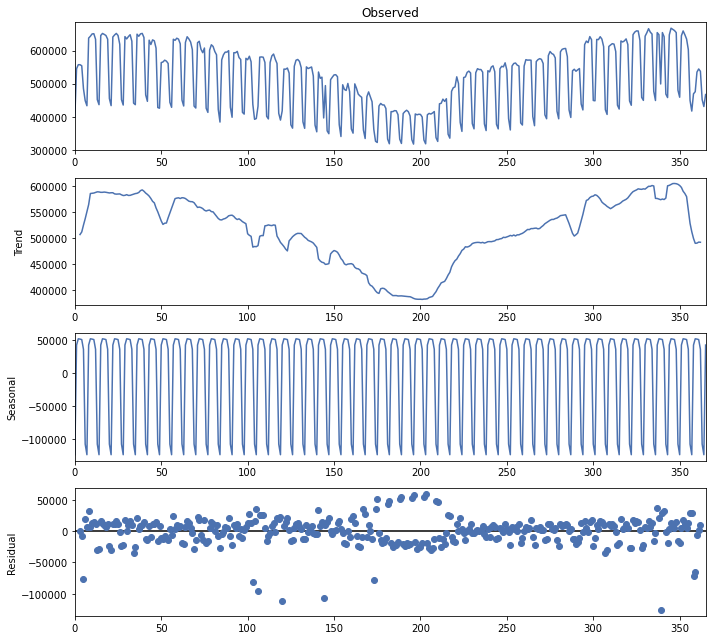

In [19]:
decompose = seasonal_decompose(ts2017.values, period = 7, model="additive")
plt.rcParams.update({'figure.figsize':(10,9)})
f = decompose.plot()


Now, we can see the trends and the seasonality clearly. And, the residuals resembles white noise to some extent, indicating that the model is a good fit. However, it also exhibits some abnormalities with clear patterns, especially in the summer period. This suggests that the residuals also erroneously take into account of the trend component, a "leakage". The problem mostly stems from this method of decomposition itself, being an outdated technique. 

Thus, we can overcome this by substituting it for a novel, more sophisticated decomposition method called STL decomposition. It is implemented in the class [STL](https://www.statsmodels.org/devel/generated/statsmodels.tsa.seasonal.STL.html) in the same package.

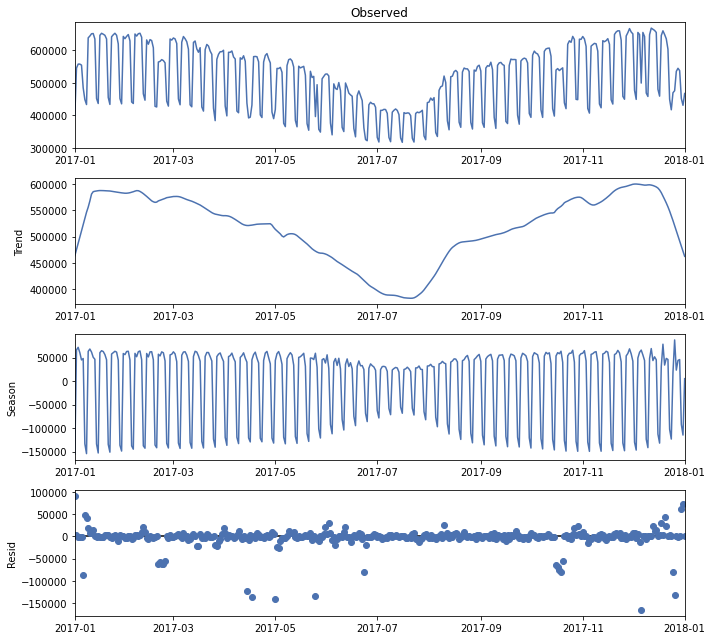

In [13]:
stl = STL(ts2017,seasonal=7,robust=True)
res = stl.fit()
fig = res.plot()

We can see that the quality of the decomposition is much better. From this, we can see that the trends and seasonality are still very much present. Therefore, there are some detrending and deseasonalizing to do in the next step - modelling. 